In [159]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Input datasets

## Flensburg

Includes three years of operation with feed flow and return flow temperatures

In [160]:
# data from https://doi.org/10.5281/zenodo.2562658
df = pd.read_csv("./district-heating-network-data-flensburg-2014-2016.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%d/%m/%y %H:%M")
# select 2014 as sample year
df = df.loc[df["Datetime"].dt.year == 2014].copy()

## DEKADE

Is a normed profile from 82 profiles from all over Germany, does include
ambient temperature (all values by arithmetic mean).

In [161]:
df_norm = pd.read_excel("dekade_mean_q_norm_and_temp.xlsx")
df_norm["Temp"] -= 273.15
df_norm["Temp"] = df_norm["Temp"].round(1)
df_norm["T_feed"] = np.nan
df_norm["dt"] = pd.to_datetime(df_norm["dt"])

## Compare normalized data with Flensburg data

Structure matches very well, we will use DEKADE moving forward

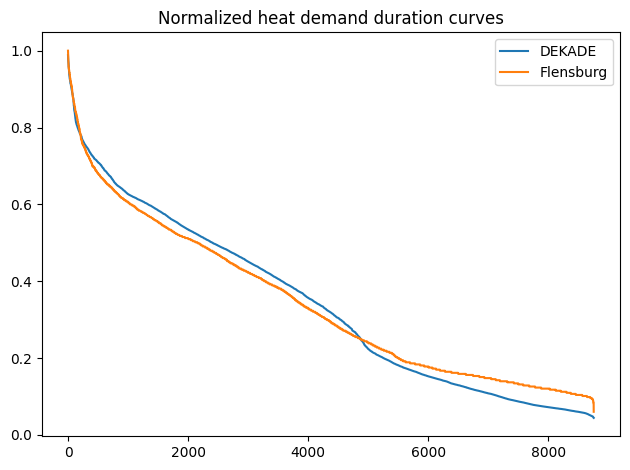

In [162]:
fig, ax = plt.subplots()

ax.set_title("Normalized heat demand duration curves")

ax.plot(range(8760), df_norm["Q/Q_max"].sort_values(ascending=False), label="DEKADE")
ax.plot(range(8760), (df["Overall heat load in MW"] / df["Overall heat load in MW"].max()).sort_values(ascending=False), label="Flensburg")

ax.legend()

plt.tight_layout()


## Calculate feed-flow temperatures with Heizkurve

Depending on ambient temperature map the feed-flow temperature

- 75 °C for T ambient below -5 °C
- 55 °C for T ambient above 15 °C
- linear interpolation in between

In [163]:
T_feed_max = 80
T_feed_min = 60

T_amb_max = 15
T_amb_min = -5

T_feed_max_mask = df_norm["Temp"] <= T_amb_min
T_feed_min_mask = df_norm["Temp"] >= T_amb_max
T_feed_linear = ~(T_feed_max_mask | T_feed_min_mask)


In [164]:
df_norm.loc[T_feed_max_mask, "T_feed"] = T_feed_max
df_norm.loc[T_feed_min_mask, "T_feed"] = T_feed_min
df_norm.loc[T_feed_linear, "T_feed"] = T_feed_min + (T_feed_max - T_feed_min) * (
    (T_amb_max - df_norm.loc[T_feed_linear, "Temp"]) / (T_amb_max - T_amb_min)
)

Check if linear interpolation produced the desired results

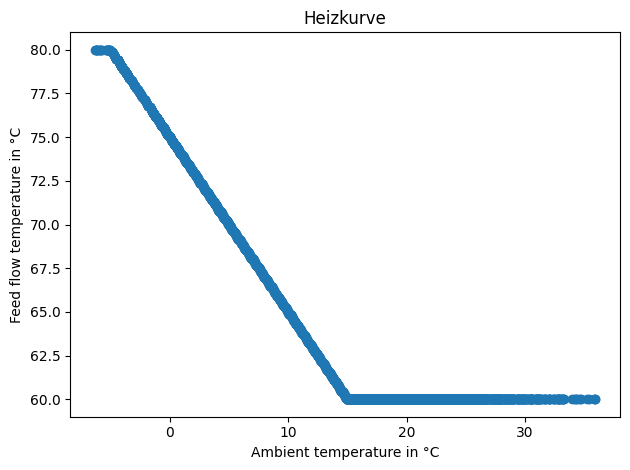

In [165]:
fig, ax = plt.subplots(1)

ax.scatter(df_norm["Temp"], df_norm["T_feed"])
ax.set_ylabel("Feed flow temperature in °C")
ax.set_xlabel("Ambient temperature in °C")

ax.set_title("Heizkurve")

plt.tight_layout()

## Scaling heat demand data to make heat pump fit into it

In [166]:
df_norm["Q"] = df_norm["Q/Q_max"] * 3000

## Aggregating to daily values

In [167]:
df_daily = df_norm.groupby(by=df_norm["dt"].dt.dayofyear).agg(
    {
        "dt": "first",
        "T_feed": "mean",
        "Q": "mean"
    }
)

## Operation pattern: spring to fall

In [168]:
heat_nomnial_heat_pump = 700
heat_minimum_heat_pump = heat_nomnial_heat_pump * 0.4

offset = 0

heat_nomnial_heat_pump += offset
heat_minimum_heat_pump += offset

df_daily["heat_pump"] = df_daily["Q"]

mask_max = df_daily["Q"] > heat_nomnial_heat_pump
df_daily.loc[mask_max, "heat_pump"] = heat_nomnial_heat_pump

mask_min = df_daily["Q"] < heat_minimum_heat_pump
df_daily.loc[mask_min, "heat_pump"] = 0

mask_winter = (df_daily["dt"].dt.dayofyear < 31+ 28 + 20) | (df_daily["dt"].dt.dayofyear > 365 - 11)
df_daily.loc[mask_winter, "heat_pump"] = 0

In [169]:
# df_daily["heat_pump"].sort_values(ascending=False).shift(10, fill_value=0)

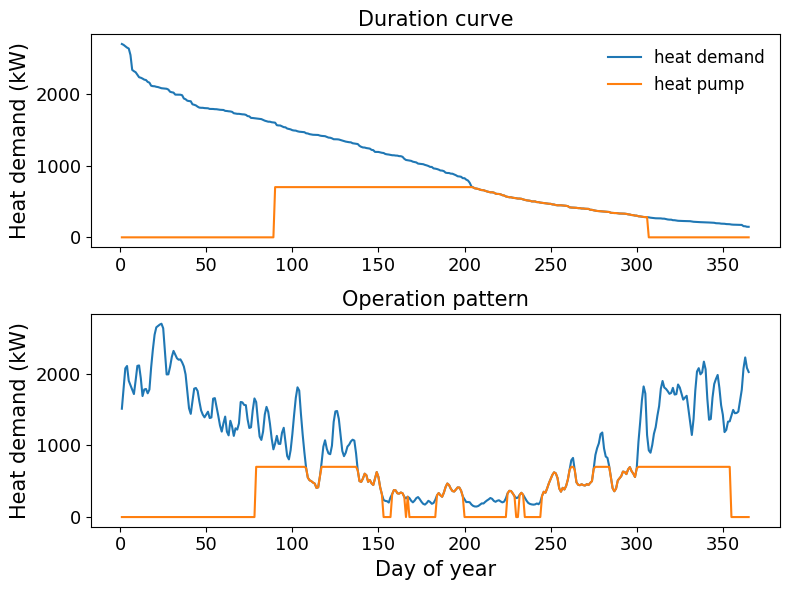

In [170]:
fig, ax = plt.subplots(2, figsize=(8, 6))

ax[0].plot(df_daily.index, df_daily["Q"].sort_values(ascending=False), label="heat demand")
ax[0].plot(df_daily.index, df_daily["heat_pump"].sort_values(ascending=False).shift(89, fill_value=0), label="heat pump")

ax[1].plot(df_daily.index, df_daily["Q"], label="heat demand")
ax[1].plot(df_daily.index, df_daily["heat_pump"], label="heat pump")

ax[0].set_title("Duration curve", fontsize=15)
ax[0].set_ylabel("Heat demand (kW)", fontsize=15)
ax[0].tick_params(axis="x", labelsize=13)
ax[0].tick_params(axis="y", labelsize=13)

ax[1].set_title("Operation pattern", fontsize=15)
ax[1].set_xlabel("Day of year", fontsize=15)
ax[1].set_ylabel("Heat demand (kW)", fontsize=15)
ax[1].tick_params(axis="x", labelsize=13)
ax[1].tick_params(axis="y", labelsize=13)
ax[0].legend(frameon=False, loc="upper right", prop={'size': 12})

plt.tight_layout()

fig.savefig("operation_heat_pump_summer.pdf")

In [171]:
df_daily["heat_pump"].sum()

127188.28923424383

In [172]:
df_daily.to_csv("operation_heat_pump_summer.csv")

## Operation pattern: fall to spring

In [173]:
offset = 800

heat_nomnial_heat_pump += offset
heat_minimum_heat_pump += offset

df_daily_winter = df_daily.copy()

df_daily_winter["heat_pump"] = df_daily_winter["Q"]

mask_max = df_daily_winter["Q"] > heat_nomnial_heat_pump
df_daily_winter.loc[mask_max, "heat_pump"] = heat_nomnial_heat_pump

mask_min = df_daily_winter["Q"] < heat_minimum_heat_pump
df_daily_winter.loc[mask_min, "heat_pump"] = 0

mask_on = df_daily_winter["heat_pump"] > 0
df_daily_winter.loc[mask_on, "heat_pump"] -= offset


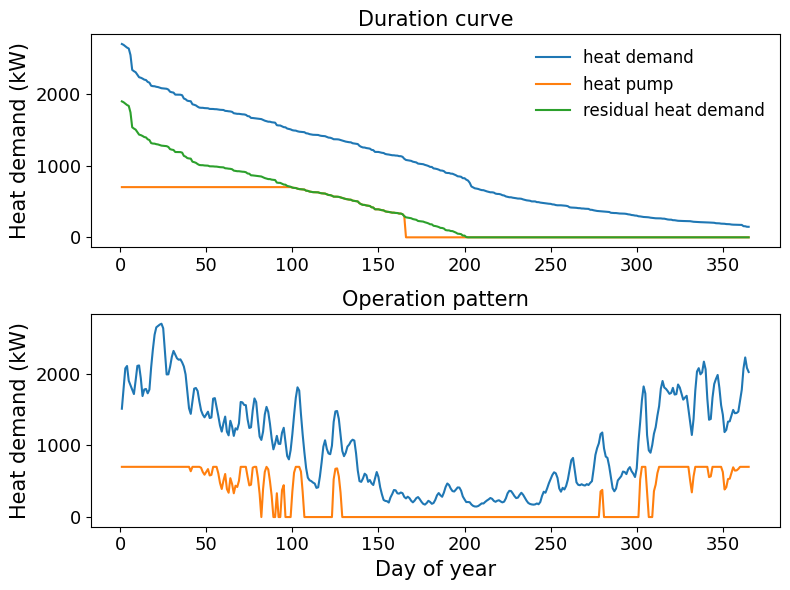

In [174]:
fig, ax = plt.subplots(2, figsize=(8, 6))

_df_daily_winter = df_daily_winter.copy()
_df_daily_winter["residual demand"] = _df_daily_winter["Q"] - offset
_df_daily_winter.loc[_df_daily_winter["residual demand"] < 0, "residual demand"] = 0

ax[0].plot(df_daily_winter.index, (_df_daily_winter["Q"]).sort_values(ascending=False), label="heat demand")
ax[0].plot(df_daily_winter.index, df_daily_winter["heat_pump"].sort_values(ascending=False), label="heat pump")
ax[0].plot(df_daily_winter.index, _df_daily_winter["residual demand"].sort_values(ascending=False), label="residual heat demand")

ax[1].plot(df_daily_winter.index, _df_daily_winter["Q"], label="heat demand")
ax[1].plot(df_daily_winter.index, df_daily_winter["heat_pump"], label="heat pump")
# ax[1].plot(df_daily_winter.index, offset * mask_on, label="heat pump")

ax[0].set_title("Duration curve", fontsize=15)
ax[0].set_ylabel("Heat demand (kW)", fontsize=15)
ax[0].tick_params(axis="x", labelsize=13)
ax[0].tick_params(axis="y", labelsize=13)

ax[1].set_title("Operation pattern", fontsize=15)
ax[1].set_xlabel("Day of year", fontsize=15)
ax[1].set_ylabel("Heat demand (kW)", fontsize=15)
ax[1].tick_params(axis="x", labelsize=13)
ax[1].tick_params(axis="y", labelsize=13)
ax[0].legend(frameon=False, loc="upper right", prop={'size': 12})

plt.tight_layout()

fig.savefig("operation_heat_pump_winter.pdf")

In [175]:
df_daily_winter["heat_pump"].sum()

103055.76213734408

In [176]:
df_daily_winter.to_csv("operation_heat_pump_winter.csv")

In [177]:
df_result_summer = pd.read_csv("cop_datasetR290_summer.csv")
df_result_winter = pd.read_csv("cop_datasetR290_winter.csv")

df_T_summer = pd.read_csv("Outflow_temperature_summer.csv")
df_T_winter = pd.read_csv("Outflow_temperature_winter.csv")

df_result_summer["T"] = df_T_summer["avg(temperature_BHE1 (0))"]
df_result_winter["T"] = df_T_winter["avg(temperature_BHE1 (0))"]

df_result_summer = df_result_summer.groupby(df_result_summer["Time"] // 1).agg({"cop": "mean", "T": "mean"})
df_result_winter = df_result_winter.groupby(df_result_winter["Time"] // 1).agg({"cop": "mean", "T": "mean"})

In [178]:
df_result_summer["T_feed"] = df_daily["T_feed"]
df_result_summer["heat"] = df_daily["heat_pump"]
df_result_winter["T_feed"] = df_daily_winter["T_feed"]
df_result_winter["heat"] = df_daily_winter["heat_pump"]

In [179]:
df_result_summer = df_result_summer.iloc[1:].copy()
df_result_winter = df_result_winter.iloc[1:].copy()

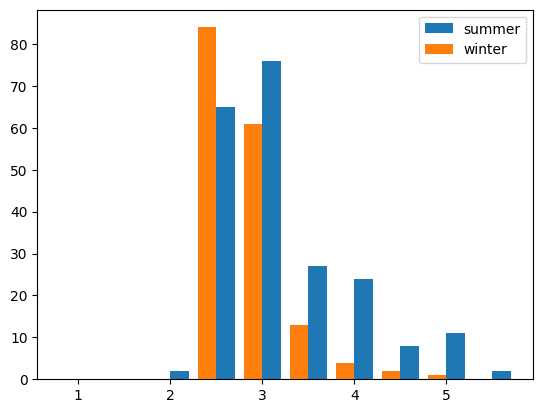

In [180]:
bins = np.linspace(1, 6, 11)
binned = pd.cut(df_result_summer.loc[df_result_summer["cop"] > 0, "cop"], bins, labels=bins[:-1])
counts = binned.value_counts().sort_index()
plt.bar([c + .1 for c in counts.index], counts, width=0.2, label="summer")
binned = pd.cut(df_result_winter.loc[df_result_winter["cop"] > 0, "cop"], bins, labels=bins[:-1])
counts = binned.value_counts().sort_index()
plt.bar([c - .1 for c in counts.index.values], counts, width=0.2, label="winter")

plt.legend()

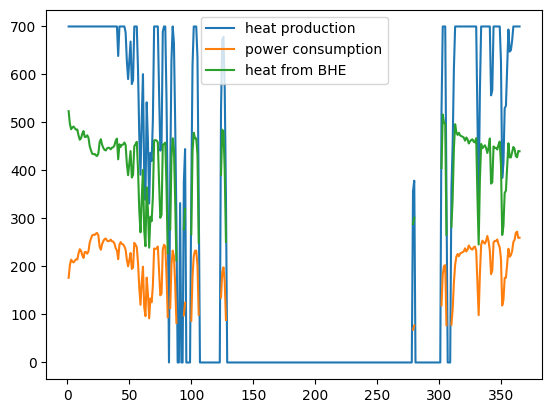

In [181]:
plt.plot(df_daily_winter["heat_pump"], label="heat production")
# plt.twinx()
plt.plot(df_daily_winter["heat_pump"] / df_result_winter["cop"], label="power consumption")
plt.plot(df_daily_winter["heat_pump"] * (1 - 1 / df_result_winter["cop"]), label="heat from BHE")
plt.legend()

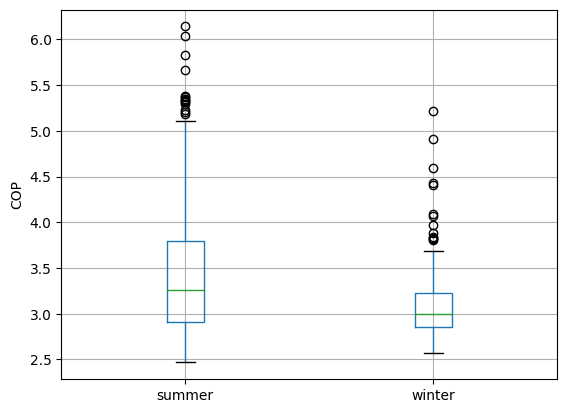

In [182]:
df = pd.DataFrame()
df["summer"] = df_result_summer["cop"]
df["winter"] = df_result_winter["cop"]
df.loc[df["summer"] == 0, "summer"] = np.nan
df.loc[df["winter"] == 0, "winter"] = np.nan

fig, ax = plt.subplots(1)
df.boxplot(ax=ax)

ax.set_ylabel("COP")

fig.savefig("boxplot-winter-summer.pdf")

In [183]:
# fig, ax = plt.subplots(2)
# ax[0].scatter(df_result_summer["cop"][1:], df_daily["heat_pump"], c=df_daily["T_feed"], vmin=60, vmax=80, cmap="coolwarm")
# _ = ax[1].scatter(df_result_winter["cop"][1:], df_daily_winter["heat_pump"], c=df_daily_winter["T_feed"], vmin=60, vmax=80, cmap="coolwarm")
# fig.colorbar(_)

# fig.savefig("")

df_result_winter["cop"]

Time
1.0      3.967125
2.0      3.448894
3.0      3.269604
4.0      3.330390
5.0      3.357651
           ...   
361.0    2.738652
362.0    2.591730
363.0    2.567911
364.0    2.699229
365.0    2.693420
Name: cop, Length: 365, dtype: float64

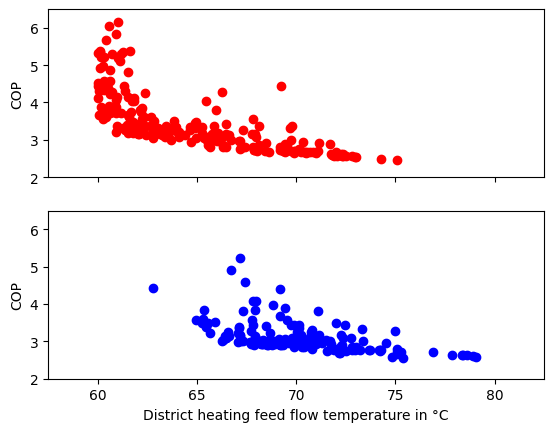

In [184]:
fig, ax = plt.subplots(2, sharex=True)

mask = df_result_summer["cop"] > 0

ax[0].scatter(df_result_summer.loc[mask, "T_feed"], df_result_summer.loc[mask, "cop"], color="red")

mask = df_result_winter["cop"] > 0

ax[1].scatter(df_result_winter.loc[mask, "T_feed"], df_result_winter.loc[mask, "cop"], color="blue")

ax[1].set_xlim(57.5, 82.5)
[_.set_ylim(2, 6.5) for _ in ax]
[_.set_ylabel("COP") for _ in ax]

ax[1].set_xlabel("District heating feed flow temperature in °C")

fig.savefig("COP_district_heating_temperature.pdf")

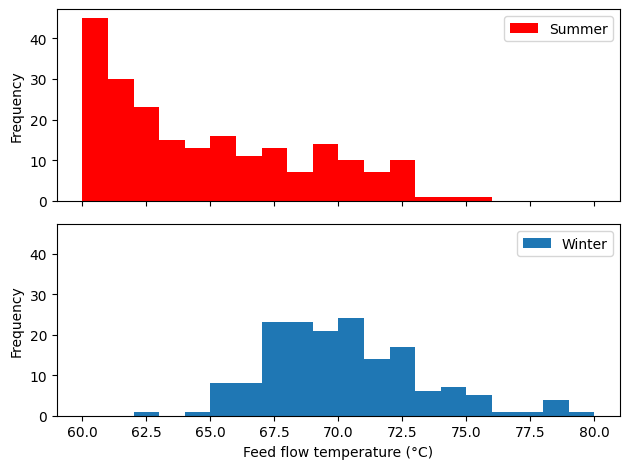

In [185]:
fig, ax = plt.subplots(2, sharex=True, sharey=True)

bins = np.arange(60, 81, 1)
mask = df_result_summer["cop"] > 0
df_daily.loc[mask, "T_feed"].plot.hist(ax=ax[0], bins=bins, color="red", label="Summer")

mask = df_result_winter["cop"] > 0
df_daily_winter.loc[mask, "T_feed"].plot.hist(ax=ax[1], bins=bins, label="Winter")

ax[0].legend()
ax[1].legend()

ax[1].set_xlabel("Feed flow temperature (°C)")

plt.tight_layout()

fig.savefig("histogram_feed_flow_temperature.pdf")

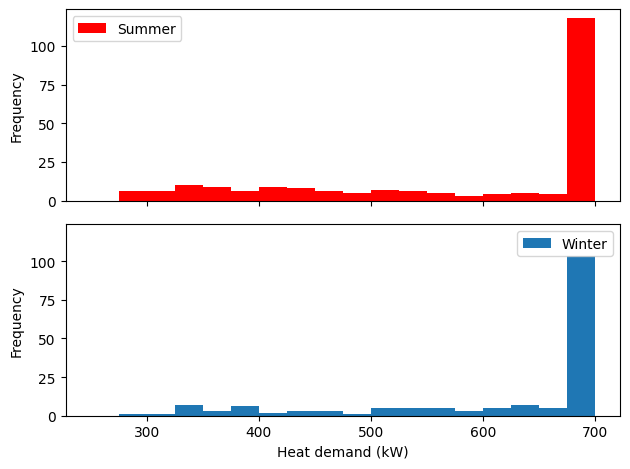

In [186]:

fig, ax = plt.subplots(2, sharex=True, sharey=True)

bins = np.arange(250, 701, 25)
mask = df_result_summer["cop"] > 0
df_result_summer.loc[mask, "heat"].plot.hist(ax=ax[0], bins=bins, color="red", label="Summer")

mask = df_result_winter["cop"] > 0
df_result_winter.loc[mask, "heat"].plot.hist(ax=ax[1], bins=bins, label="Winter")

ax[0].legend()
ax[1].legend()

ax[1].set_xlabel("Heat demand (kW)")

plt.tight_layout()

fig.savefig("histogram_heat_demand.pdf")

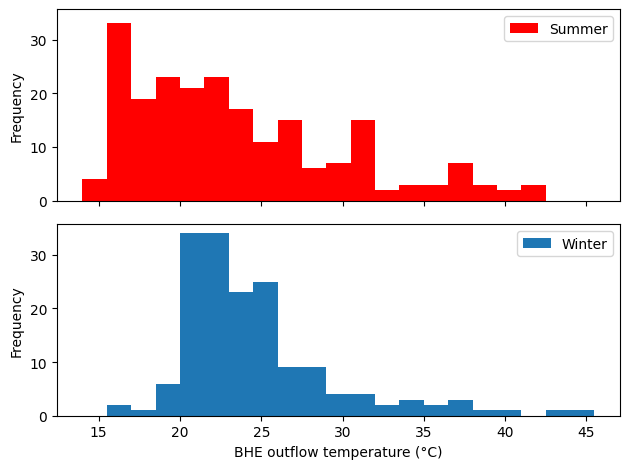

In [187]:
fig, ax = plt.subplots(2, sharex=True, sharey=True)

bins = np.arange(14, 47, 1.5)
mask = df_result_summer["cop"] > 0
df_result_summer.loc[mask, "T"].plot.hist(ax=ax[0], bins=bins, color="red", label="Summer")

mask = df_result_winter["cop"] > 0
df_result_winter.loc[mask, "T"].plot.hist(ax=ax[1], bins=bins, label="Winter")

ax[0].legend()
ax[1].legend()

# [_.set_ylim(0, 60) for _ in ax]

ax[1].set_xlabel("BHE outflow temperature (°C)")

plt.tight_layout()

fig.savefig("histogram_bhe_outflow_temperature.pdf")

In [188]:
df_result_summer[mask]

,cop,T,T_feed,heat
Time,,,,
1.0,0.0,16.558406,68.845833,0.0
2.0,0.0,15.891048,72.450000,0.0
3.0,0.0,15.595128,74.970833,0.0
4.0,0.0,15.452846,73.329167,0.0
5.0,0.0,15.377045,70.154167,0.0
...,...,...,...,...
361.0,0.0,16.263377,71.575000,0.0
362.0,0.0,16.279557,74.850000,0.0
363.0,0.0,16.290061,75.395833,0.0


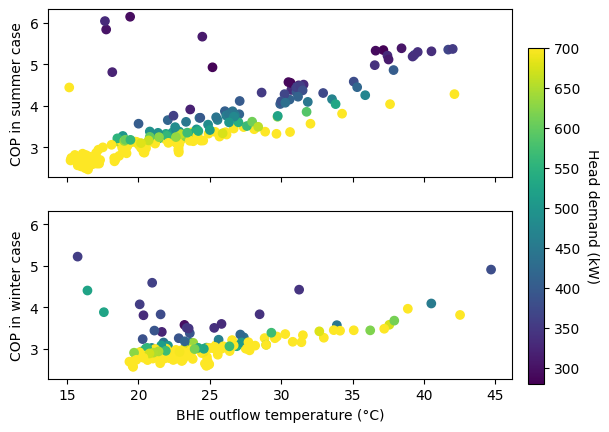

In [189]:
fig, ax = plt.subplots(2, sharex=True, sharey=True)

mask = df_result_summer["cop"] > 0
_ = ax[0].scatter(df_result_summer.loc[mask, "T"], df_result_summer.loc[mask, "cop"], vmin=280, vmax=700, c=df_result_summer.loc[mask, "heat"])#, s=df_result_summer.loc[mask, "heat"] / 25)

mask = df_result_winter["cop"] > 0
_ = ax[1].scatter(df_result_winter.loc[mask, "T"], df_result_winter.loc[mask, "cop"], vmin=280, vmax=700, c=df_result_winter.loc[mask, "heat"])#, s=df_result_summer.loc[mask, "heat"] / 25)

fig.subplots_adjust(right=0.85)

cbar_ax = fig.add_axes([0.875, 0.1, 0.025, 0.7])
cbar = fig.colorbar(_, cax=cbar_ax)
cbar.ax.set_ylabel("Head demand (kW)", rotation=-90, va="bottom")

# ax[1].set_xlim(57.5, 82.5)
# [_.set_ylim(2, 6.5) for _ in ax]
ax[0].set_ylabel("COP in summer case")
ax[1].set_ylabel("COP in winter case")

ax[1].set_xlabel("BHE outflow temperature (°C)")

# plt.tight_layout()

fig.savefig("COP_vs_BHE_outflow_temperature_vs_heat_demand.pdf")

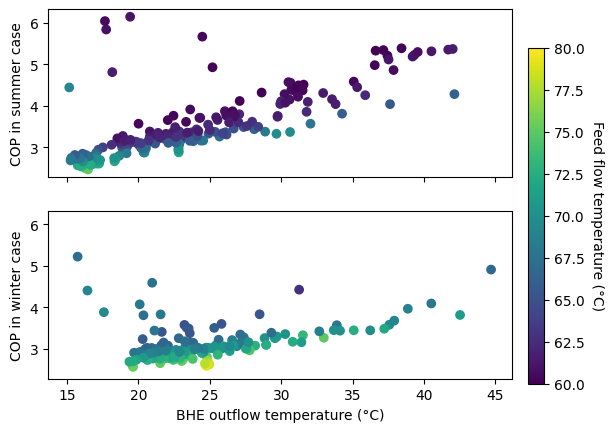

In [190]:

fig, ax = plt.subplots(2, sharex=True, sharey=True)

mask = df_result_summer["cop"] > 0

_ = ax[0].scatter(df_result_summer.loc[mask, "T"], df_result_summer.loc[mask, "cop"], vmin=60, vmax=80, c=df_result_summer.loc[mask, "T_feed"])#, s=df_result_summer.loc[mask, "heat"] / 25)

mask = df_result_winter["cop"] > 0
_ = ax[1].scatter(df_result_winter.loc[mask, "T"], df_result_winter.loc[mask, "cop"], vmin=60, vmax=80, c=df_result_winter.loc[mask, "T_feed"])#, s=df_result_summer.loc[mask, "heat"] / 25)

fig.subplots_adjust(right=0.85)

cbar_ax = fig.add_axes([0.875, 0.1, 0.025, 0.7])
cbar = fig.colorbar(_, cax=cbar_ax)
cbar.ax.set_ylabel("Feed flow temperature (°C)", rotation=-90, va="bottom")

ax[0].set_ylabel("COP in summer case")
ax[1].set_ylabel("COP in winter case")

ax[1].set_xlabel("BHE outflow temperature (°C)")

# plt.tight_layout()

fig.savefig("COP_vs_BHE_outflow_temperature_vs_feed_flow.pdf")

In [191]:
df_result_winter

,cop,T,T_feed,heat
Time,,,,
1.0,3.967125,38.865308,68.845833,700.0
2.0,3.448894,35.078220,72.450000,700.0
3.0,3.269604,32.982434,74.970833,700.0
4.0,3.330390,31.516726,73.329167,700.0
5.0,3.357651,30.281285,70.154167,700.0
...,...,...,...,...
361.0,2.738652,19.856883,71.575000,700.0
362.0,2.591730,19.592813,74.850000,700.0
363.0,2.567911,19.628817,75.395833,700.0


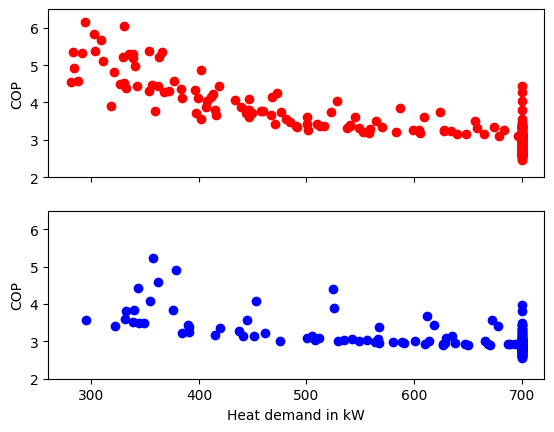

In [192]:
fig, ax = plt.subplots(2, sharex=True)

mask = df_result_summer["cop"] > 0

ax[0].scatter(df_result_summer.loc[mask, "heat"], df_result_summer.loc[mask, "cop"], color="red")

mask = df_result_winter["cop"] > 0

ax[1].scatter(df_result_winter.loc[mask, "heat"], df_result_winter.loc[mask, "cop"], color="blue")

# ax[1].set_xlim(57.5, 82.5)
[_.set_ylim(2, 6.5) for _ in ax]
[_.set_ylabel("COP") for _ in ax]

ax[1].set_xlabel("Heat demand in kW")

fig.savefig("COP_district_heating_temperature.pdf")

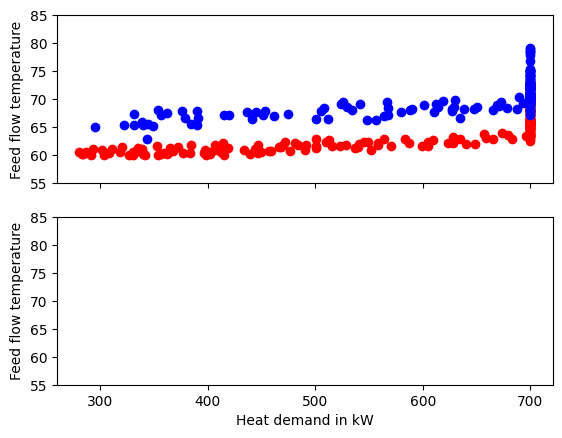

In [193]:
fig, ax = plt.subplots(2, sharex=True)

mask = df_result_summer["cop"] > 0

ax[0].scatter(df_result_summer.loc[mask, "heat"], df_result_summer.loc[mask, "T_feed"], color="red")

mask = df_result_winter["cop"] > 0

ax[0].scatter(df_result_winter.loc[mask, "heat"], df_result_winter.loc[mask, "T_feed"], color="blue")

# ax[1].set_xlim(57.5, 82.5)
[_.set_ylim(55, 85) for _ in ax]
[_.set_ylabel("Feed flow temperature") for _ in ax]

ax[1].set_xlabel("Heat demand in kW")

fig.savefig("Feed_flow_temperature_vs_heat_demand.pdf")

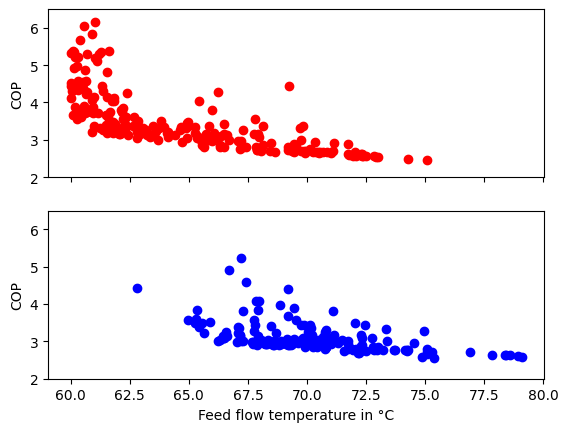

In [194]:
fig, ax = plt.subplots(2, sharex=True)

mask = df_result_summer["cop"] > 0

ax[0].scatter(df_result_summer.loc[mask, "T_feed"], df_result_summer.loc[mask, "cop"], color="red")

mask = df_result_winter["cop"] > 0

ax[1].scatter(df_result_winter.loc[mask, "T_feed"], df_result_winter.loc[mask, "cop"], color="blue")

# ax[1].set_xlim(57.5, 82.5)
[_.set_ylim(2, 6.5) for _ in ax]
[_.set_ylabel("COP") for _ in ax]

ax[1].set_xlabel("Feed flow temperature in °C")

fig.savefig("COP_vs_feed_flow_temperature.pdf")

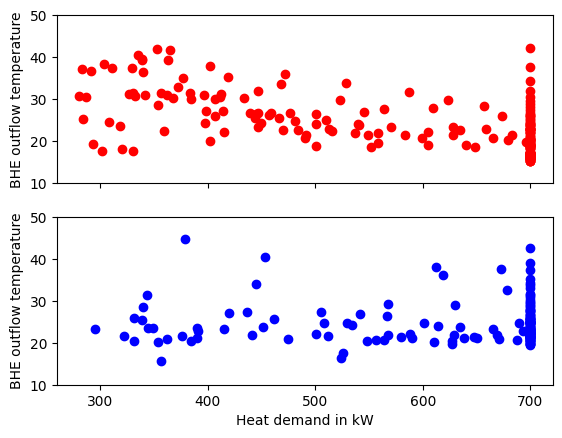

In [195]:

fig, ax = plt.subplots(2, sharex=True)

mask = df_result_summer["cop"] > 0

ax[0].scatter(df_result_summer.loc[mask, "heat"], df_result_summer.loc[mask, "T"], color="red")

mask = df_result_winter["cop"] > 0

ax[1].scatter(df_result_winter.loc[mask, "heat"], df_result_winter.loc[mask, "T"], color="blue")

# ax[1].set_xlim(57.5, 82.5)
[_.set_ylim(10, 50) for _ in ax]
[_.set_ylabel("BHE outflow temperature") for _ in ax]

ax[1].set_xlabel("Heat demand in kW")

fig.savefig("BHE_outflow_vs_heat_demand.pdf")